### Customer Segmentation using RFM Analysis

The dataset which contains all the transactions occuring between 1/1/2019 and 1/1/2021 for Ralco. Our goal is to find the segment the customers based on RFM so that the company can target its customers efficiently. The segmentation performed using two different clustering methods; K-means and quantile. 

**RFM (Recency Frequency Monetary) analysis** is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

- Recency – How recently did the customer purchase?
- Frequency – How often do they purchase?
- Monetary – How much do they spend?

#### Data Import

In [5]:
import pandas as pd
output = pd.read_pickle("data/data_file.pkl")

#### Data Engineering

In [9]:
output['InvoiceDate']= pd.to_datetime(output['InvoiceDate'])
df = output[output['InvoiceDate'] >= '2019-01-01']
df = df.groupby(['CustomerID','InvoiceDate'], as_index=False).agg({'Name': 'count',  # Item #    
                                                'Quantity': lambda x: x.sum(),          # Total Quantity
                                                'TotalSales': lambda x: x.sum()})       # Monetary
df.rename(columns={'Name': 'Item_No'}, inplace=True)
print(df.head(), '\n-------------------------------------------------------------')
print(df.isnull().sum()) # No of missing value

   CustomerID InvoiceDate  Item_No  Quantity  TotalSales
0           2  2019-01-10        1      40.0     32550.4
1           2  2019-01-21        1      40.0     32550.4
2           2  2019-02-11        1      40.0     32550.4
3           2  2019-02-12        1      40.0     32550.4
4           2  2019-02-27        1      40.0      3062.0 
-------------------------------------------------------------
CustomerID     0
InvoiceDate    0
Item_No        0
Quantity       0
TotalSales     0
dtype: int64


In [11]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
# Create the RFM Table
output = pd.read_pickle("data/data_file.pkl")
output['InvoiceDate']= pd.to_datetime(output['InvoiceDate'])
df = output[output['InvoiceDate'] > '2019-01-01']
NOW = datetime.datetime(2022,4,28)
rfmTable = df.groupby('CustomerID', as_index=False).agg({'InvoiceDate': lambda x: (NOW - x.max()).days, # Recency
                                        'TotalSales': lambda x: x.sum(),                                # Monetary
                                        'Quantity': lambda x: x.sum()})                                 # Total Items
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'Quantity': 'quantity_total',
                         'TotalSales': 'monetary'}, inplace=True)
rfmTable['frequency'] = df.groupby(['CustomerID'], as_index=False).agg({'InvoiceDate': lambda x: x.nunique()})['InvoiceDate'] # Frequency
print(rfmTable.head(), '\n-------------------------------------------------------------')
print(rfmTable.isnull().sum()) # No of missing value
rfmTable.to_pickle("data/rfm_file.pkl")

   CustomerID  recency      monetary  quantity_total  frequency
0           2      178  2.180923e+06        152360.0         87
1           3      853  2.888000e+01             1.0          1
2           4      196  4.179130e+04         55116.0         42
3           5      185  7.704104e+04         12591.0         18
4           7      217  5.102667e+03           543.0         48 
-------------------------------------------------------------
CustomerID        0
recency           0
monetary          0
quantity_total    0
frequency         0
dtype: int64


#### K-means Clustering

In [77]:
from sklearn.preprocessing import StandardScaler
rfmTable = pd.read_pickle("data/rfm_file.pkl")
rfm_segmentation = rfmTable.copy()
rfm_segmentation.drop(rfm_segmentation.columns[-2], axis=1, inplace=True)
# Rescaling the attributes
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_segmentation.iloc[:,1:4])
rfm_scaled = pd.DataFrame(rfm_scaled)
rfm_scaled.columns = ['recency', 'monetary', 'frequency']
rfm_scaled = rfm_scaled.set_index(rfm_segmentation['CustomerID'])
rfm_scaled.head()
rfm_scaled.to_pickle("data/kmeans_file.pkl")

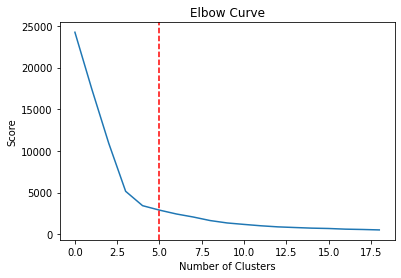

In [75]:
# Classify the customers into 20 groups using K-means clustering
# Using Elbow method to find the proper number of the clusters for our customers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
ssd = []
range_n_clusters = range(1, 20)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_scaled)
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
plt.axvline(x=5, color='red', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [14]:
# Silhouette analysis
from sklearn.metrics import silhouette_score
range_n_clusters = range(2, 10)
for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.9697525049767952
For n_clusters=3, the silhouette score is 0.6047229649261561
For n_clusters=4, the silhouette score is 0.6456502899201476
For n_clusters=5, the silhouette score is 0.6565042442190897
For n_clusters=6, the silhouette score is 0.5842233620465322
For n_clusters=7, the silhouette score is 0.5869062203854505
For n_clusters=8, the silhouette score is 0.5870820744127663
For n_clusters=9, the silhouette score is 0.5868134173093347


In [15]:
# fitting model
kmeans = KMeans(n_clusters=5, random_state=0).fit(rfm_scaled)
# creates a new column called cluster which has cluster number for each row respectively.
rfm_scaled['cluster'] = kmeans.labels_
# check groups
rfm_scaled[rfm_scaled.cluster == 0].head(10)

,recency,monetary,frequency,cluster
CustomerID,,,,
5,-1.037598,0.076645,0.606374,0
10,-0.635249,-0.068927,-0.023579,0
15,-0.571384,-0.051895,0.081413,0
19,-0.242480,0.227873,0.553878,0
23,0.121550,-0.068248,-0.233563,0
25,-0.421301,0.032302,0.133909,0
26,-0.210547,-0.058084,-0.076075,0
28,-0.466007,-0.052493,-0.181067,0
29,-0.970539,-0.008753,0.291398,0


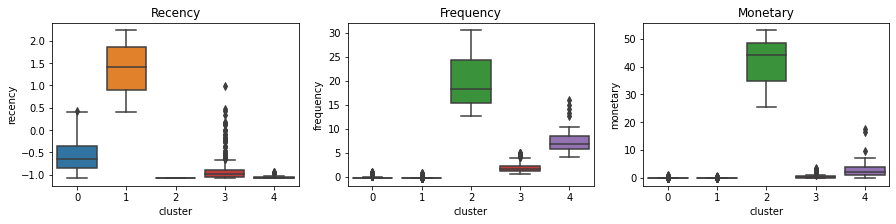

In [17]:
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(15,3))
sns.boxplot(x=rfm_scaled.cluster,y=rfm_scaled.recency, ax=axes[0]).set(title='Recency')
sns.boxplot(x=rfm_scaled.cluster,y=rfm_scaled.frequency, ax=axes[1]).set(title='Frequency')
sns.boxplot(x=rfm_scaled.cluster,y=rfm_scaled.monetary, ax=axes[2]).set(title='Monetary')
plt.show()

Based on the customer segmentation using K-means, we found out cluster 3 is the best groups with the lowest recency and highest frequency and monetary. Cluster 4 is the next best and Cluster 2. Cluster 0 is the lost customers who are stopped using our products. 

#### Quantile Clustering
Using quantile to group the customers and finding the list of best, loyal and lost customers.

In [60]:
# Catogorizing R,F,M into 4 groups using quantiles
rfmTable = pd.read_pickle("data/rfm_file.pkl")
quartiles = rfmTable.quantile(q=[0.2,0.4,0.6,0.8,1])
print(quartiles)
quartiles=quartiles.to_dict()

     CustomerID  recency      monetary  quantity_total  frequency
0.2      5322.6    240.0  1.544000e+01    1.000000e+00        1.0
0.4      9710.4    321.0  9.178000e+01    3.000000e+00        1.0
0.6     11814.6    458.6  4.543000e+02    2.000000e+01        2.0
0.8     13339.8    841.0  4.371632e+03    4.588000e+02        6.0
1.0     14703.0   1212.0  2.803280e+07    1.472749e+07      589.0


In [65]:
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1
def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5
rfmTable['R_Quartile'] = rfmTable['recency'].apply(RScore, args=('recency',quartiles,))
rfmTable['F_Quartile'] = rfmTable['frequency'].apply(FMScore, args=('frequency',quartiles,))
rfmTable['M_Quartile'] = rfmTable['monetary'].apply(FMScore, args=('monetary',quartiles,))
rfmTable['Q_Quartile'] = rfmTable['quantity_total'].apply(FMScore, args=('quantity_total',quartiles,))
rfmTable['RFMScore'] = rfmTable['R_Quartile'].astype(str) + rfmTable['F_Quartile'].astype(str) + rfmTable['M_Quartile'].astype(str) 
rfmTable['Total Score'] = rfmTable['R_Quartile'] + rfmTable['F_Quartile'] + rfmTable['M_Quartile']
print(rfmTable.head())
rfmTable.to_pickle("data/rfm_file2.pkl")

   CustomerID  recency      monetary  quantity_total  frequency  R_Quartile  \
0           2      178  2.180923e+06        152360.0         87           5   
1           3      853  2.888000e+01             1.0          1           1   
2           4      196  4.179130e+04         55116.0         42           5   
3           5      185  7.704104e+04         12591.0         18           5   
4           7      217  5.102667e+03           543.0         48           5   

   F_Quartile  M_Quartile  Q_Quartile RFMScore  Total Score  
0           5           5           5      555           15  
1           1           2           1      112            4  
2           5           5           5      555           15  
3           5           5           5      555           15  
4           5           5           5      555           15  


Segments
- Best: bought recently, buy often and spend the most
- Loyal: spend good money, responsive to promotions
- New Customer: bought recently, but not often
- Lost: lowest recency, highest frequency, and monetary scores
- Lost LowVolume: lowest recency, frequency, and monetary score

In [73]:
# https://www.kaggle.com/code/ekrembayar/rfm-analysis-online-retail-ii
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfmTable['Segment'] = rfmTable['R_Quartile'].astype(str) + rfmTable['F_Quartile'].astype(str)
rfmTable['Segment'] = rfmTable['Segment'].replace(seg_map, regex=True)
rfmTable.head()

,CustomerID,recency,monetary,quantity_total,frequency,R_Quartile,F_Quartile,M_Quartile,Q_Quartile,RFMScore,Total Score,Segment
0,2,178,2.180923e+06,152360.0,87,5,5,5,5,555,15,Champions
1,3,853,2.888000e+01,1.0,1,1,1,2,1,112,4,Hibernating
2,4,196,4.179130e+04,55116.0,42,5,5,5,5,555,15,Champions
3,5,185,7.704104e+04,12591.0,18,5,5,5,5,555,15,Champions
4,7,217,5.102667e+03,543.0,48,5,5,5,5,555,15,Champions


In [74]:
rfmStats = rfmTable[["Segment","recency","frequency", "monetary"]].groupby("Segment").agg(["mean","median","count", "std"])
rfmStats.columns = rfmStats.columns.map('_'.join).str.strip('|')
rfmStats

,recency_mean,recency_median,recency_count,recency_std,frequency_mean,frequency_median,frequency_count,frequency_std,monetary_mean,monetary_median,monetary_count,monetary_std
Segment,,,,,,,,,,,,
About to Sleep,377.740409,372.0,782,36.836565,1.000000,1.0,782,0.000000,445.624718,16.1800,782,2.228847e+03
At Risk,794.009514,785.0,946,214.331882,2.895349,2.0,946,1.155909,3272.755654,441.7150,946,1.593097e+04
Can't Loose,672.693642,611.0,173,172.244735,13.815029,11.0,173,10.574234,29514.779841,8132.3500,173,5.615873e+04
Champions,204.929885,210.0,870,22.041355,29.668966,15.0,870,44.277978,253779.110182,19654.7950,870,1.436943e+06
Hibernating,890.309585,921.5,1544,228.610849,1.000000,1.0,1544,0.000000,666.179563,72.7825,1544,2.730482e+03
Loyal Customers,325.772121,311.0,825,65.111305,9.372121,6.0,825,10.093781,15004.391504,1652.4300,825,4.292636e+04
Need Attention,385.632911,386.0,158,39.432011,2.000000,2.0,158,0.000000,1673.834541,261.2000,158,5.653665e+03
New Customers,212.888889,217.0,378,19.417877,1.000000,1.0,378,0.000000,1143.498069,11.4200,378,2.810274e+03
Potential Loyalists,248.980620,244.0,258,39.515593,2.000000,2.0,258,0.000000,2150.338362,224.3850,258,4.998537e+03


In [66]:
# https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales
print("- Best Customers: ",len(rfmTable[rfmTable['RFMScore']=='555']))
print("- Loyal Customers: ",len(rfmTable[rfmTable['F_Quartile']==5]))
print("- Big Spenders: ",len(rfmTable[rfmTable['M_Quartile']==5]))
print("- New Customers: ",len(rfmTable[rfmTable['RFMScore']=='511']))
print("- Need Attention Customers: ",len(rfmTable[(rfmTable['RFMScore']=='222') ]))
print("- Almost Lost: ",len(rfmTable[rfmTable['RFMScore']=='255']))
print("- Lost Customers: ",len(rfmTable[rfmTable['RFMScore']=='155']))
print("- Lost LowVolume Customers: ",len(rfmTable[rfmTable['RFMScore']=='111']))

- Best Customers:  514
- Loyal Customers:  1202
- Big Spenders:  1332
- New Customers:  214
- Need Attention Customers:  0
- Almost Lost:  86
- Lost Customers:  21
- Lost LowVolume Customers:  104


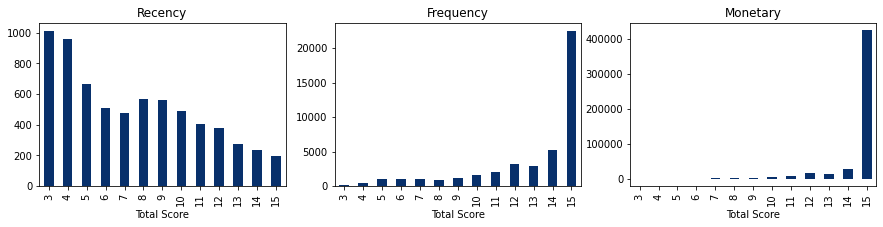

In [67]:
# Frequency Plots by Total Score
fig, axes = plt.subplots(1, 3, figsize=(15,3))
rfmTable.groupby('Total Score')['recency'].mean().plot(kind='bar', colormap='Blues_r', ax=axes[0]).set(title='Recency')
rfmTable.groupby('Total Score')['frequency'].sum().plot(kind='bar', colormap='Blues_r', ax=axes[1]).set(title='Frequency')
rfmTable.groupby('Total Score')['monetary'].mean().plot(kind='bar', colormap='Blues_r', ax=axes[2]).set(title='Monetary')
plt.show()

In [70]:
# Best 10 customers
rfmTable[rfmTable['RFMScore']=='555'].sort_values(['Total Score','quantity_total'],ascending=False).head(10)

,CustomerID,recency,monetary,quantity_total,frequency,R_Quartile,F_Quartile,M_Quartile,Q_Quartile,RFMScore,Total Score
7,11,171,1.336441e+07,1.472749e+07,589,5,5,5,5,555,15
11,18,170,2.803280e+07,1.450067e+07,354,5,5,5,5,555,15
64,91,171,2.324087e+07,9.664518e+06,248,5,5,5,5,555,15
1294,5214,177,9.317760e+06,6.018946e+06,160,5,5,5,5,555,15
234,639,170,8.649094e+06,4.421592e+06,158,5,5,5,5,555,15
3452,10930,177,9.330971e+05,4.191332e+06,112,5,5,5,5,555,15
16,24,171,3.531332e+06,3.955986e+06,138,5,5,5,5,555,15
389,1093,184,2.738992e+06,2.216738e+06,102,5,5,5,5,555,15
266,740,171,3.322250e+06,2.133927e+06,168,5,5,5,5,555,15
71,107,182,1.379008e+06,2.014519e+06,310,5,5,5,5,555,15


array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'5'}>]], dtype=object)

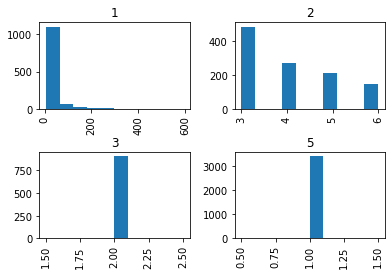

In [27]:
#rfmTable.groupby('F_Quartile')['frequency'].sum()
rfmTable['frequency'].hist(by=rfmTable['F_Quartile'])

### Hierarchical Clustering

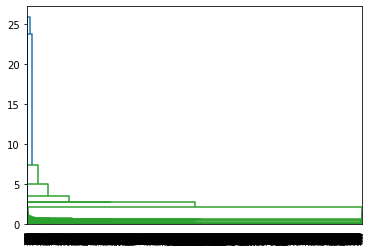

In [78]:
# https://www.kaggle.com/code/hellbuoy/online-retail-k-means-hierarchical-clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Single linkage: 
rfm_scaled =pd.read_pickle("data/kmeans_file.pkl")
mergings = linkage(rfm_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

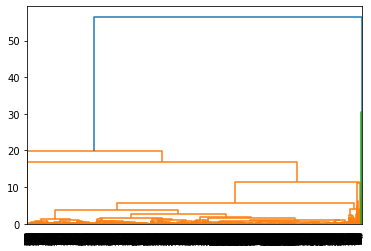

In [79]:
# Complete linkage
mergings = linkage(rfm_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

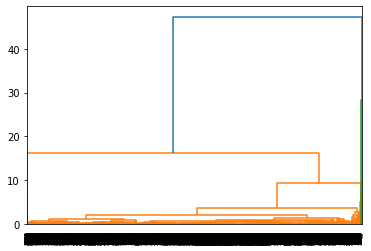

In [80]:
# Average linkage
mergings = linkage(rfm_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

<AxesSubplot:xlabel='Cluster_Labels', ylabel='recency'>

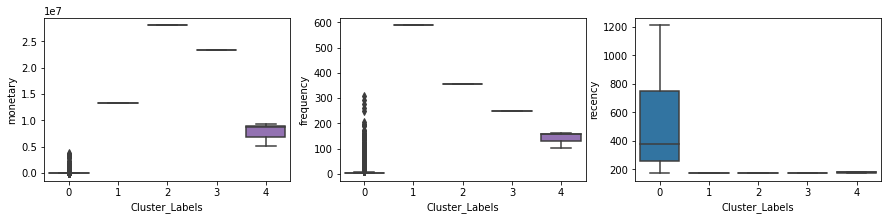

In [82]:
# Plot Cluster Id vs Amount
# 5 clusters
cluster_labels = cut_tree(mergings, n_clusters=5).reshape(-1, )
cluster_labels
rfmTable = pd.read_pickle("data/rfm_file.pkl") 
rfmTable['Cluster_Labels'] = cluster_labels
rfmTable.head()
fig, axes = plt.subplots(1, 3, figsize=(15,3))
sns.boxplot(x='Cluster_Labels', y='monetary', data=rfmTable,ax=axes[0])
sns.boxplot(x='Cluster_Labels', y='frequency', data=rfmTable,ax=axes[1])
sns.boxplot(x='Cluster_Labels', y='recency', data=rfmTable,ax=axes[2])